In [1]:
# https://docs.ultralytics.com/tasks/segment/#predict

In [2]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.164 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [3]:
# Train YOLOv8n on COCO128 for 3 epochs
!yolo train model=yolov8n.pt data=coco128.yaml epochs=3 imgsz=640

100% 6.23M/6.23M [00:00<00:00, 109MB/s]
Ultralytics YOLOv8.0.164 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco128.yaml, epochs=3, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchs

# Custom Train

## 데이터 준비

In [4]:
#download and copy labelme data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/datasets/jetson_seg.zip -d .

Archive:  /content/drive/MyDrive/datasets/jetson_seg.zip
   creating: ./jetson_seg/train/
   creating: ./jetson_seg/train/calib_image/
   creating: ./jetson_seg/train/calib_image/calib_images/
  inflating: ./jetson_seg/train/calib_image/calib_images/1058.jpg  
  inflating: ./jetson_seg/train/calib_image/calib_images/1058.json  
  inflating: ./jetson_seg/train/calib_image/calib_images/1143.jpg  
  inflating: ./jetson_seg/train/calib_image/calib_images/1143.json  
  inflating: ./jetson_seg/train/calib_image/calib_images/1159.jpg  
  inflating: ./jetson_seg/train/calib_image/calib_images/1159.json  
  inflating: ./jetson_seg/train/calib_image/calib_images/1211.jpg  
  inflating: ./jetson_seg/train/calib_image/calib_images/1211.json  
  inflating: ./jetson_seg/train/calib_image/calib_images/1226.jpg  
  inflating: ./jetson_seg/train/calib_image/calib_images/1226.json  
  inflating: ./jetson_seg/train/calib_image/calib_images/145.jpg  
  inflating: ./jetson_seg/train/calib_image/calib_image

In [6]:
data_name = 'jetson_seg'#!!!!!!!!!!!!!!!!!!!!!!!!!!

from genericpath import exists
import os
root = '/content/datasets/' + data_name

dir_images_train = os.path.join(root, 'images/train')
dir_images_val = os.path.join(root, 'images/val')
dir_labels_train = os.path.join(root, 'labels/train')
dir_labels_val = os.path.join(root, 'labels/val')

# os.makedirs(dir_images_train, exist_ok=True)
# os.makedirs(dir_images_val, exist_ok=True)
# os.makedirs(dir_labels_train, exist_ok=True)
# os.makedirs(dir_labels_val, exist_ok=True)
for dir in [dir_images_train, dir_images_val, dir_labels_train, dir_labels_val]:
    os.makedirs(dir, exist_ok=True)


In [7]:
#!!!!!!!!!!!!!!!!!!!!!!!
label_dict = {
    'front':0,
    'back':1
}

In [8]:
import json
import cv2
import numpy as np

meta_train = []
meta_valid = []

for root, dirs, filenames in os.walk(data_name):
    #train valid....
    if 'train' in root:
        meta = meta_train
    elif 'valid' in root:
        meta = meta_valid
    else:
        continue
    for filename in filenames:
        first, last = os.path.splitext(filename)

        if last != '.jpg':
            continue

        json_path = os.path.join(root, first + '.json')
        if not os.path.exists(json_path):
            continue

        jpg_path = os.path.join(root, filename)
        data = json.load(open(json_path, 'r'))
        height = data['imageHeight']
        width = data['imageWidth']

        labels = []
        polys = []

        for shape in data['shapes']:
            label_txt = shape['label']

            if label_txt not in label_dict:
                print(label_txt, json_path)
                continue
            label = label_dict[label_txt]

            points = shape['points']
            points = np.array(points, dtype=np.float32)
            points[:, 0] = points[:, 0] / width
            points[:, 1] = points[:, 1] / height
            poly = points.reshape(-1)

            labels.append(label)
            polys.append(poly)

        if len(labels) == 0:
            continue

        meta.append((jpg_path, labels, polys))


In [9]:
len(meta_train), len(meta_valid)

(33, 20)

In [10]:
meta_train

[('jetson_seg/train/calib_image/calib_images/1226.jpg',
  [0],
  [array([    0.18476,     0.31384,      0.3295,     0.97856,      0.6398,     0.89084,      0.6398,     0.86355,       0.642,     0.83236,     0.64529,     0.80897,     0.64419,     0.78558,     0.64419,     0.76998,     0.64309,     0.74854,     0.64419,     0.73294,       0.642,      0.7154,     0.47862,    0.068226],
         dtype=float32)]),
 ('jetson_seg/train/calib_image/calib_images/1159.jpg',
  [1],
  [array([    0.16831,     0.93372,       0.483,     0.94542,     0.48958,    0.083821,     0.19353,     0.27096], dtype=float32)]),
 ('jetson_seg/train/calib_image/calib_images/514.jpg',
  [0],
  [array([    0.34814,      0.5614,     0.64638,     0.62768,     0.67818,     0.26121,     0.43037,     0.17349], dtype=float32)]),
 ('jetson_seg/train/calib_image/calib_images/770.jpg',
  [1],
  [array([    0.38871,     0.19688,     0.33607,     0.88889,     0.66678,     0.99815,     0.91502,     0.99815,     0.86787,     0.2

In [11]:
# !rm -rf datasets/hands_bd

In [12]:
dir_images_train

'/content/datasets/jetson_seg/images/train'

In [13]:
dir_labels_train

'/content/datasets/jetson_seg/labels/train'

In [14]:
import shutil

filenum = 0
for data, dir_images, dir_labels in [(meta_train, dir_images_train, dir_labels_train),
                                     (meta_valid, dir_images_val, dir_labels_val)]:
    for path, labels, polys in data:
        filename = str(filenum)
        dst_path = os.path.join(dir_images, filename + '.jpg')

        # shutil.copyfile(path, dst_path)
        image = cv2.imread(path)
        if image is None:
            print("None", path)
        cv2.imwrite(dst_path, image)

        txt_path = os.path.join(dir_labels, filename + '.txt')

        with open(txt_path, 'w') as f:
            for label, poly in zip(labels, polys):
                f.write(f'{label}')
                for p in poly:
                    f.write(f' {p:.5f}')
                f.write('\n')

        filenum += 1
#실행 결과 : datasets 폴더에 '[data_name]'폴더가 만들어지고 내용이 채워진다.

In [15]:
file = open(data_name + '.yaml', 'w')
file.write(f'path: ../datasets/{data_name}\n')
file.write('train: images/train\n')  # train images (relative to 'path') 128 images
file.write('val: images/val\n')# val images (relative to 'path') 128 images
file.write('names:\n')
for key, value in label_dict.items():
    file.write(f'  {value}: {key}\n')
file.close()
#실행 결과 : [data_name].yaml 이 만들어진다.

# 학습 - detection

In [16]:
#!!!!!!!!!!!!!!!!! data=yaml파일 이름 신경쓰기!
!yolo train model=yolov8n.pt data=jetson_seg.yaml epochs=100 imgsz=640 fliplr=0.0 degrees=180.0 name=jetson_box hsv_s=0.1

Ultralytics YOLOv8.0.164 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=jetson_seg.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=jetson_box, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=

In [17]:
!yolo train model=yolov8n.pt data=jetson_seg.yaml epochs=30 imgsz=640 fliplr=0.0 degrees=180.0 name=jetson_box hsv_s=0.1

Ultralytics YOLOv8.0.164 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=jetson_seg.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=jetson_box, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=F

# 활용

In [19]:
from ultralytics import YOLO
model = YOLO('/content/runs/detect/jetson_box2/weights/last.pt')


image 1/1 /content/jetson_seg/valid/429.jpg: 384x640 1 back, 84.9ms
Speed: 3.6ms preprocess, 84.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


tensor(0.9747, device='cuda:0')


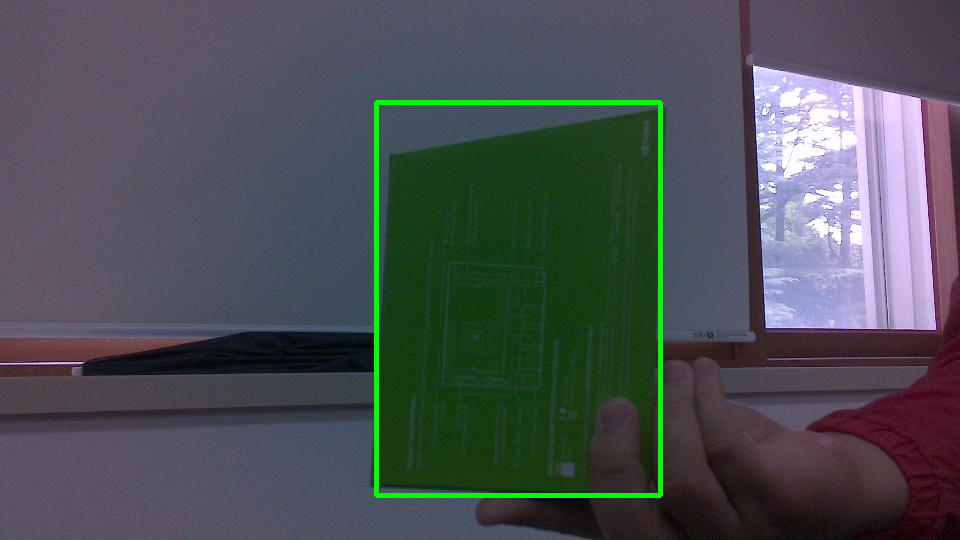

In [20]:
image_path ='/content/jetson_seg/valid/429.jpg'
result = model(image_path)
image = cv2.imread(image_path)
for x1, y1, x2, y2, conf, cat in result[0].boxes.data:
    print(conf)
    if cat == 0:
        color = (255, 0, 0)
    elif cat == 1:
        color = (0, 255, 0)
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [21]:
result[0].boxes.data

tensor([[376.5818, 102.0206, 660.7001, 495.0969,   0.9747,   1.0000]], device='cuda:0')

# export

In [22]:
!yolo export model=/content/runs/detect/jetson_box2/weights/best.pt format=onnx

Ultralytics YOLOv8.0.164 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients

PyTorch: starting from '/content/runs/detect/jetson_box2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (5.9 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 107.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 10.6s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.14.1 opset 17...
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: export success ✅ 11.4s, saved as '/content/runs/detect/jetson_box2/weights/best.onnx' (11.7 MB)

Expo

In [23]:
!cp /content/runs/detect/jetson_box2/weights/jetson_box.onnx drive/MyDrive

cp: cannot stat '/content/runs/detect/jetson_box2/weights/jetson_box.onnx': No such file or directory


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.5 MB/s eta 0:00:00


In [27]:
import onnxruntime
import cv2

ort_session = onnxruntime.InferenceSession("/content/runs/detect/jetson_box2/weights/best.onnx")

image = cv2.imread('/content/jetson_seg/valid/429.jpg')
image = cv2.resize(image, (640, 640))[..., ::-1]
input = (image / 255).astype(np.float32).transpose(2, 0, 1)[None]

# compute ONNX Runtime output prediction
ort_inputs = {'images': input}
ort_outs = ort_session.run(None, ort_inputs)

ort_outs[0].shape

(1, 6, 8400)

In [28]:
ort_outs[0][0][4:].max()

0.050767213

# 학습 - segmentation

In [29]:
# 모델만 segment로 바꿔준다.
!yolo train model=yolov8n-seg.pt data=jetson_seg.yaml epochs=100 imgsz=640 fliplr=0.0 degrees=180.0 name=jetson_seg hsv_s=0.1

100% 6.73M/6.73M [00:00<00:00, 12.7MB/s]
Ultralytics YOLOv8.0.164 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=jetson_seg.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=jetson_seg, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=Tr

In [30]:
from ultralytics import YOLO
model = YOLO('runs/segment/jetson_seg/weights/last.pt')

In [31]:
image_path ='/content/jetson_seg/valid/429.jpg'
image = cv2.imread(image_path)
result = model(image)


0: 384x640 1 back, 43.1ms
Speed: 2.9ms preprocess, 43.1ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


tensor(0.9895, device='cuda:0')


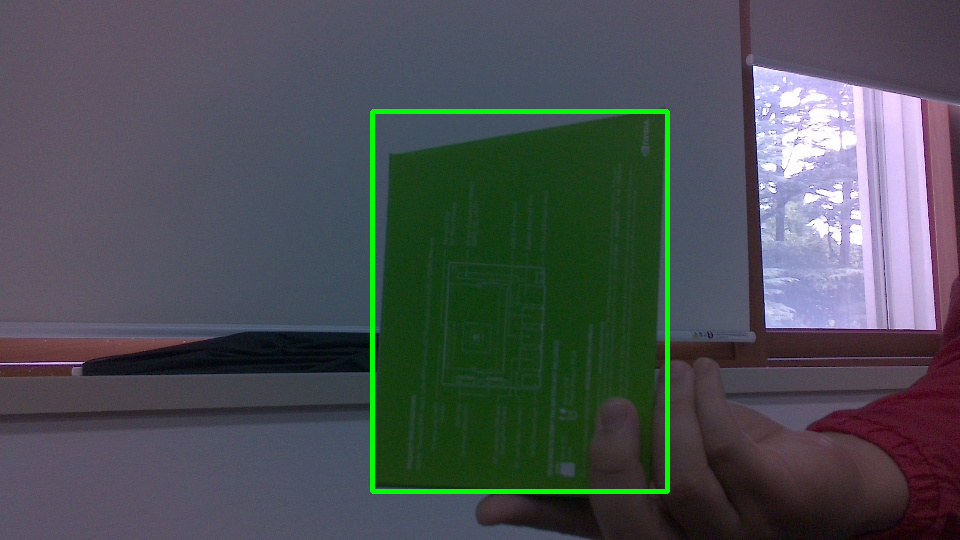

In [32]:
for x1, y1, x2, y2, conf, cat in result[0].boxes.data:
    print(conf)
    if cat == 0:
        color = (255, 0, 0)
    elif cat == 1:
        color = (0, 255, 0)
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [33]:
result[0].masks.data.to('cpu').shape[0]

1

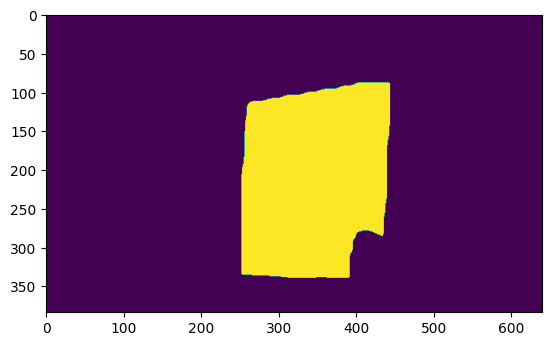

In [34]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
plt.imshow(result[0].masks.to('cpu').data[0])

In [35]:
model.export(format='onnx')

Ultralytics YOLOv8.0.164 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/segment/jetson_seg/weights/last.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 38, 8400), (1, 32, 160, 160)) (6.4 MB)

ONNX: starting export with onnx 1.14.1 opset 17...
ONNX: export success ✅ 1.7s, saved as 'runs/segment/jetson_seg/weights/last.onnx' (12.6 MB)

Export complete (4.0s)
Results saved to /content/runs/segment/jetson_seg/weights
Predict:         yolo predict task=segment model=runs/segment/jetson_seg/weights/last.onnx imgsz=640 
Validate:        yolo val task=segment model=runs/segment/jetson_seg/weights/last.onnx imgsz=640 data=jetson_seg.yaml 
Visualize:       https://netron.app


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



'runs/segment/jetson_seg/weights/last.onnx'

In [36]:
import onnxruntime
import cv2

ort_session = onnxruntime.InferenceSession("/content/runs/segment/jetson_seg/weights/last.onnx")

image = cv2.imread('/content/jetson_seg/valid/429.jpg')
image = cv2.resize(image, (640, 640))[..., ::-1]
input = (image / 255).astype(np.float32).transpose(2, 0, 1)[None]

# compute ONNX Runtime output prediction
ort_inputs = {'images': input}
ort_outs = ort_session.run(None, ort_inputs)

In [37]:
len(ort_outs)

2

In [38]:
ort_outs[0].shape

(1, 38, 8400)

In [39]:
ort_outs[0][0].transpose()[:, 6]

array([     -0.524,    -0.49104,    -0.42614, ...,    0.083156,    0.091975,    0.045228], dtype=float32)

In [40]:
for i in range(32):
    plt.imshow(ort_outs[1][0, i])
    plt.title(str(i))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [41]:
det = ort_outs[0][0].transpose()
max_prob = det[:, 4:6].max(axis=1)
max_cat = det[:, 4:6].argmax(axis=1)
index = max_prob > 0.3
det = det[index]
boxes = det[:, :4]
weights = det[:, 6:]
prob = max_prob[index]
cat = max_cat[index]
res = np.c_[boxes, prob, cat, weights]
res = sorted(res, key=lambda x:x[4])


In [42]:
#NMS 생략하고.. 물체가 하나뿐이라고 가정하면
item = res[0]
w = item[6:]

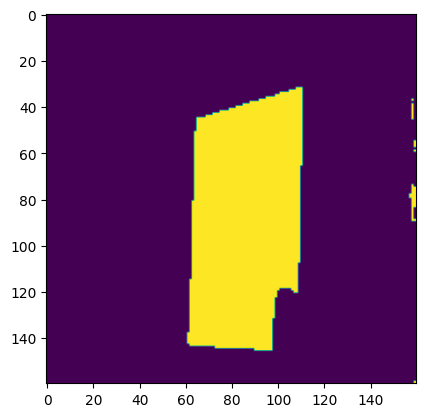

In [43]:
segs = ort_outs[1][0]
w_segs = w.reshape(-1, 1, 1) * segs
final = w_segs.sum(axis=0)
plt.imshow(final > 0) #최종 결과를 크롭해야 하는데 귀찮

In [44]:
#여러 물체가 한꺼번에 등장하면서 겹쳐지는 상황이면 쓸만한데 (instance segmentation 상황)
#물체끼리 segmentation을 분리해야 하는 상황이 아니라면 그냥 u2net이 낫다. (semantic segmentation 상황)
#참고 : https://89douner.tistory.com/113